In [11]:
from PIL import Image

In [12]:
import dlib
import numpy as np
import skvideo.io

In [13]:
def get_frames_mouth(detector, predictor, frames):
        MOUTH_WIDTH = 100
        MOUTH_HEIGHT = 50
        HORIZONTAL_PAD = 0.19
        normalize_ratio = None
        mouth_frames = []
        for frame in frames:
            dets = detector(frame, 1)
            shape = None
            for k, d in enumerate(dets):
                shape = predictor(frame, d)
                i = -1
            if shape is None: # Detector doesn't detect face, just return as is
                return frames
            mouth_points = []
            for part in shape.parts():
                i += 1
                if i < 48: # Only take mouth region
                    continue
                mouth_points.append((part.x,part.y))
            np_mouth_points = np.array(mouth_points)

            mouth_centroid = np.mean(np_mouth_points[:, -2:], axis=0)

            if normalize_ratio is None:
                mouth_left = np.min(np_mouth_points[:, :-1]) * (1.0 - HORIZONTAL_PAD)
                mouth_right = np.max(np_mouth_points[:, :-1]) * (1.0 + HORIZONTAL_PAD)

                normalize_ratio = MOUTH_WIDTH / float(mouth_right - mouth_left)

            new_img_shape = (int(frame.shape[1] * normalize_ratio), int(frame.shape[0]* normalize_ratio))
            #resized_img = imresize(frame, new_img_shape)
            resized_img=np.array(Image.fromarray(frame).resize(new_img_shape))

            mouth_centroid_norm = mouth_centroid * normalize_ratio

            mouth_l = int(mouth_centroid_norm[0] - MOUTH_WIDTH / 2)
            mouth_r = int(mouth_centroid_norm[0] + MOUTH_WIDTH / 2)
            mouth_t = int(mouth_centroid_norm[1] - MOUTH_HEIGHT / 2)
            mouth_b = int(mouth_centroid_norm[1] + MOUTH_HEIGHT / 2)

            mouth_crop_image = resized_img[mouth_t:mouth_b, mouth_l:mouth_r]

            mouth_frames.append(mouth_crop_image)
        return mouth_frames

In [24]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('./shape_predictor_68_face_landmarks.dat')

In [25]:
 def get_video_frames(path):
        videogen = skvideo.io.vreader(path)
        frames = np.array([frame for frame in videogen])
        return frames

In [26]:
frames=get_video_frames('/Users/manideepkolla/Downloads/test_fold/pretrain/5957285425744490519/00062.mp4')

In [27]:
mouth=get_frames_mouth(detector, predictor, frames)

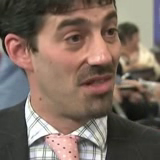

In [29]:
i=Image.fromarray(mouth[21])
i

In [34]:
frames.shape

(429, 224, 224, 3)

In [36]:
np.asarray(mouth).shape

(429, 50, 100, 3)

In [37]:
outputdata = np.asarray(mouth)

writer = skvideo.io.FFmpegWriter("outputvideo.mp4")
for i in range(outputdata.shape[0]):
        writer.writeFrame(outputdata[i, :, :, :])
writer.close()